In [1]:
import os 
import netCDF4 as nc 
import xarray as xa
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import analysis

#### constants

In [114]:
NUM_BIO_CHANNELS = 64
NUM_AUX_CHANNELS = 4
NUM_CHANNELS = NUM_BIO_CHANNELS + NUM_AUX_CHANNELS
folder = Path('test_data')
filepath = folder / 'test.nc'

if filepath.exists():
    os.remove(filepath)

metadata = {}
metadata['subject'] = 'Spencer'
metadata['session_number'] = 1
metadata['electrode_type'] = '8x8'
metadata['num_channels'] = NUM_CHANNELS
metadata['num_bio_channels'] = NUM_BIO_CHANNELS
metadata['num_aux_channels'] = NUM_AUX_CHANNELS

def setup_new_netcdf_file(filepath, metadata, verbose=False):
    if filepath.exists():
        raise ValueError("This file already exists!")
    with nc.Dataset(filepath,mode='w',format='NETCDF4') as ncfile:
        
        # attributes
        for attr in metadata.keys():
            ncfile.setncattr(attr, metadata[attr])

        ncfile.num_bio_channels = NUM_BIO_CHANNELS
        ncfile.num_aux_and_acc_channels = NUM_AUX_CHANNELS    

        # dimensions
        ncfile.createDimension('bio_channels', (ncfile.num_bio_channels))
        ncfile.createDimension('aux_and_acc_channels',
                               (ncfile.num_aux_and_acc_channels))
        ncfile.createDimension('counter_channel', (1))
        ncfile.createDimension('time', (None))  # unlimited dimension

        # variables
        ncfile.createVariable(
            'emg', np.int32,
            ('bio_channels', 'time'))  # name, type, dimension
        ncfile.createVariable(
            'aux', np.int32,
            ('aux_and_acc_channels', 'time'))  # name, type, dimension
        ncfile.createVariable(
            'counter', np.int32,
            ('counter_channel', 'time'))  # name, type, dimension
        ncfile.createVariable('time', 'float', ('time', ))
            
#         # dimensions
#         bio_channel_dim = ncfile.createDimension('bio_channels', (ncfile.num_bio_channels))
#         aux_channel_dim = ncfile.createDimension('aux_channels', (ncfile.num_aux_channels))
#         counter_channel_dim = ncfile.createDimension('counter_channel', (1))
#         time_dim = ncfile.createDimension('time', (None)) # unlimited dimension

#         # variables
#         emg_var = ncfile.createVariable('emg', np.int32, ('bio_channels','time')) # name, type, dimension
#         aux_var = ncfile.createVariable('aux', np.int32, ('aux_channels','time')) # name, type, dimension
#         counter_var = ncfile.createVariable('counter', np.int32, ('counter_channel','time')) # name, type, dimension
#         time_var = ncfile.createVariable('time', 'float', ('time',))

        if verbose:
            print(ncfile)

def create_new_netcdf(filepath, verbose=False):
    if filepath.exists():
        raise ValueError("This file already exists!")
    with nc.Dataset(filepath, mode='w', format='NETCDF4') as ncfile:

        # attributes
        for attr in Config:
            ncfile.setncattr(attr.name.lower(), attr.value)

        
        if verbose:
            print("Created netCDF file: \n", ncfile)

def append_to_file(filepath, array):
    with nc.Dataset(filepath, mode='a', format='NETCDF4') as file:
        emg = file['emg']
        aux = file['aux']
        counter = file['counter']
        if emg.shape[0] + file.num_aux_and_acc_channels != array.shape[0]:
            raise ValueError("New data shape does not match!")
        time_start_idx = emg.shape[1]
        time_end_idx = emg.shape[1] + array.shape[1]
        emg[:, time_start_idx:
            time_end_idx] = array[:file.num_bio_channels, :]
        aux[:, time_start_idx:time_end_idx] = array[
            file.num_bio_channels:
            file.num_bio_channels + file.num_aux_and_acc_channels, :]
        counter[:, time_start_idx:time_end_idx] = array[-1, :]
            
def append_to_emg_dataset(filepath, new_data):
    with nc.Dataset(filepath,mode='a',format='NETCDF4') as file:
        emg = file['emg']
        aux = file['aux']
        counter = file['counter']
        if emg.shape[0] + NUM_AUX_CHANNELS != new_data.shape[0]:
            raise ValueError("New data shape does not match!")
        time_start_idx = emg.shape[1]
        time_end_idx = emg.shape[1]+new_data.shape[1]
        emg[:,time_start_idx:time_end_idx] = new_data[:NUM_BIO_CHANNELS,:]
        aux[:,time_start_idx:time_end_idx] = new_data[NUM_BIO_CHANNELS:NUM_CHANNELS,:]        
        counter[:,time_start_idx:time_end_idx] = new_data[-1,:]

## Working with NetCDF

For now:
- Each run of the pipeline will be a different file.
- Time is a dummy variable, but not a dummy dimension

Future:
- Figure out how to set sample times when we append (software time) 
- task data? new file?


### setup file

In [115]:
setup_new_netcdf_file(filepath, metadata)

### append data

In [116]:
shape = (68,2000)
new_data = np.ones(shape=shape)*np.arange(1,shape[1]+1)#.reshape(1,-1)
print(new_data.shape)

(68, 2000)


In [119]:
append_to_file(filepath, new_data)

(64, 4000)
(4, 4000)
(1, 4000)
(4000,)


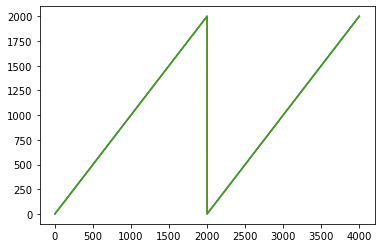

In [120]:
with nc.Dataset(filepath,mode='a',format='NETCDF4') as file:
    for var in file.variables:
        print(file[var].shape)
    plt.plot(file['counter'][0])
    plt.plot(file['aux'][0])
    plt.plot(file['emg'][45])

In [64]:
append_to_emg_dataset(filepath, np.ones((NUM_CHANNELS,500)))

### Xarray 

Make an xarray from netCDF file

<xarray.Dataset>
Dimensions:  (aux_channels: 4, bio_channels: 64, counter_channel: 1, time: 13000)
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 ... 12994 12995 12996 12997 12998 12999
Dimensions without coordinates: aux_channels, bio_channels, counter_channel
Data variables:
    emg      (bio_channels, time) int32 ...
    aux      (aux_channels, time) int32 ...
    counter  (counter_channel, time) int32 ...
Attributes:
    subject:           Spencer
    session_number:    1
    electrode_type:    8x8
    num_channels:      68
    num_bio_channels:  64
    num_aux_channels:  4


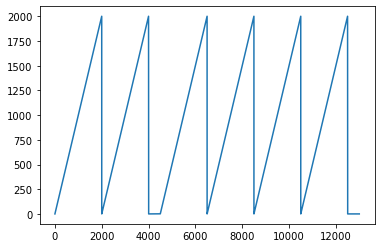

In [78]:
dataset = xa.open_dataset('test_data/test.nc')
dataset['time'] = np.arange(dataset.time.shape[0],dtype=np.int32)
plt.plot(dataset.time, dataset.counter[0])
print(dataset)
dataset.close()

In [79]:
dataset = xa.open_dataset('test_data/test.nc')
dataset

<xarray.Dataset>
Dimensions:  (aux_channels: 4, bio_channels: 64, counter_channel: 1, time: 13000)
Coordinates:
  * time     (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Dimensions without coordinates: aux_channels, bio_channels, counter_channel
Data variables:
    emg      (bio_channels, time) int32 ...
    aux      (aux_channels, time) int32 ...
    counter  (counter_channel, time) int32 ...
Attributes:
    subject:           Spencer
    session_number:    1
    electrode_type:    8x8
    num_channels:      68
    num_bio_channels:  64
    num_aux_channels:  4